In [ ]:
import pandas as pd
import re
import torch
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

# 1. Load Data
train_df = pd.read_csv("/content/drive/MyDrive/FinalTrainingOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
val_df = pd.read_csv("/content/drive/MyDrive/ValidationOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
test_df = pd.read_csv("/content/drive/MyDrive/FinalTest.tsv", sep="\t", names=["uid", "text"], header=None)

# 2. Preprocess Text (remove emojis, links, etc.)
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', 'mention', text)
    text = re.sub(r'#\w+', 'hashtag', text)
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation/emojis
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

train_df["text"] = train_df["text"].apply(clean_text)
val_df["text"] = val_df["text"].apply(clean_text)

# 3. Encode labels
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
val_df["label"] = le.transform(val_df["label"])

# 4. Load MuRIL tokenizer
checkpoint = "google/muril-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# 5. Tokenize
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

train_dataset = Dataset.from_pandas(train_df[["text", "label"]])
val_dataset = Dataset.from_pandas(val_df[["text", "label"]])

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# 6. Load MuRIL model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# 7. Training Arguments
import os
os.environ["WANDB_DISABLED"] = "true"


training_args = TrainingArguments(
    output_dir="./muril_results",
    overwrite_output_dir=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="no",
    report_to="none"  # 👈 This tells HF Trainer not to use wandb or tensorboard
)



# 8. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# 9. Train
trainer.train()

# 10. Evaluation


Map:   0%|          | 0/14594 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ValueError: Unable to avoid copy while creating an array as requested.
If using `np.array(obj, copy=False)` replace it with `np.asarray(obj)` to allow a copy when needed (no behavior change in NumPy 1.x).
For more details, see https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword.

In [ ]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

val_encodings = tokenizer(val_df["text"].tolist(), truncation=True, padding=True, return_tensors="pt", max_length=128)
val_encodings = {k: v.to(device) for k, v in val_encodings.items()}

with torch.no_grad():
    outputs = model(**val_encodings)
    predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()

val_labels = val_df["label"].to_numpy()
accuracy = accuracy_score(val_labels, predictions)
report = classification_report(val_labels, predictions, target_names=le.classes_)
conf_matrix = confusion_matrix(val_labels, predictions)

print(f"\n✅ Validation Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", report)
print("\n🧮 Confusion Matrix:\n", conf_matrix)


In [ ]:
import pandas as pd
import re
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load data
train_df = pd.read_csv("/content/drive/MyDrive/FinalTrainingOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
val_df = pd.read_csv("/content/drive/MyDrive/ValidationOnly.tsv", sep="\t", names=["uid", "text", "label"], header=None)
test_df = pd.read_csv("/content/drive/MyDrive/FinalTest.tsv", sep="\t", names=["uid", "text"], header=None)

# Clean text (remove emojis, special characters)
def clean_text(text):
    text = str(text)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF"
        u"\U00002700-\U000027BF" u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub('', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text.strip()

train_df["text"] = train_df["text"].apply(clean_text)
val_df["text"] = val_df["text"].apply(clean_text)
test_df["text"] = test_df["text"].apply(clean_text)

# Label encoding
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
val_df["label"] = le.transform(val_df["label"])

# Use MuRIL tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")

# Custom Dataset class
class HinglishDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Create dataset objects
train_dataset = HinglishDataset(train_df["text"].tolist(), train_df["label"].tolist())
val_dataset = HinglishDataset(val_df["text"].tolist(), val_df["label"].tolist())

# Load MuRIL model
model = AutoModelForSequenceClassification.from_pretrained("google/muril-base-cased", num_labels=3)

# TrainingArguments
training_args = TrainingArguments(
    output_dir="./muril_results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    logging_steps=50,
    save_steps=500,
    save_total_limit=1,
    load_best_model_at_end=False,
    report_to=[],  # disables wandb, tensorboard, etc.
    overwrite_output_dir=True
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer
)

# Train
trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/113 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/953M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/953M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1-3688475907.py:76: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,1.088400
100,1.038500
150,0.991000
200,0.985800
250,0.937900
300,0.919300
350,0.910600
400,0.904000
450,0.880000
500,0.810000


TrainOutput(global_step=2285, training_loss=0.7248735515502662, metrics={'train_runtime': 1755.8516, 'train_samples_per_second': 41.558, 'train_steps_per_second': 1.301, 'total_flos': 4799846522903040.0, 'train_loss': 0.7248735515502662, 'epoch': 5.0})


✅ Validation Accuracy: 0.8083

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84       890
           1       0.79      0.74      0.76      1128
           2       0.82      0.83      0.83       982

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000


🧮 Confusion Matrix:
 [[770  98  22]
 [130 837 161]
 [ 37 127 818]]


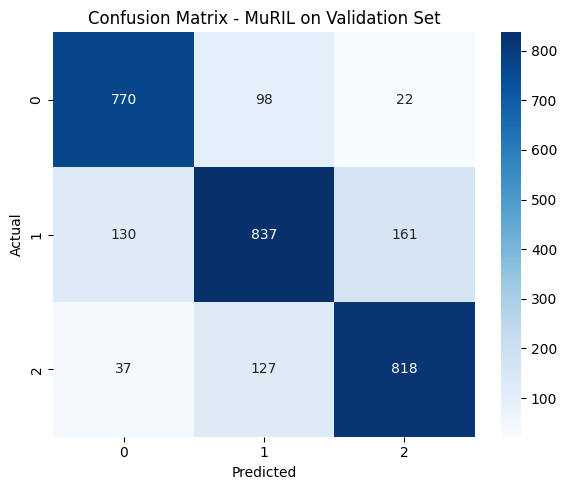

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# Put model in eval mode
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Tokenize validation data again for prediction
val_texts = val_df["text"].tolist()
val_labels = val_df["label"].tolist()

encodings = tokenizer(val_texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
encodings = {k: v.to(device) for k, v in encodings.items()}

# Predict
with torch.no_grad():
    outputs = model(**encodings)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Evaluate
accuracy = accuracy_score(val_labels, predictions)
report = classification_report(val_labels, predictions, target_names=[str(c) for c in le.classes_])
conf_matrix = confusion_matrix(val_labels, predictions)

print(f"\n✅ Validation Accuracy: {accuracy:.4f}")
print("\n📊 Classification Report:\n", report)
print("\n🧮 Confusion Matrix:\n", conf_matrix)

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MuRIL on Validation Set")
plt.tight_layout()
plt.show()
